In [19]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

## Modelisation

In [20]:
df = pd.read_csv("dataset/df_go_modelisation.csv")
df.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday
0,1,1,2,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.559420,4.725720,1,3,0,2,1,9,1,2,6,2
1,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.559420,4.725720,1,6,0,2,2,1,1,7,6,2
2,1,1,2,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.925810,6.346200,2,6,0,2,8,15,1,4,3,3
3,1,1,1,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.925810,6.346200,2,5,0,2,1,1,1,6,3,3
4,1,1,1,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.493162,-2.760439,2,6,0,2,1,2,1,3,6,3


In [21]:
df['mois'].value_counts().sort_values(ascending=False)

KeyError: 'mois'

Text(0.5, 1.0, 'Variables corrélées ')

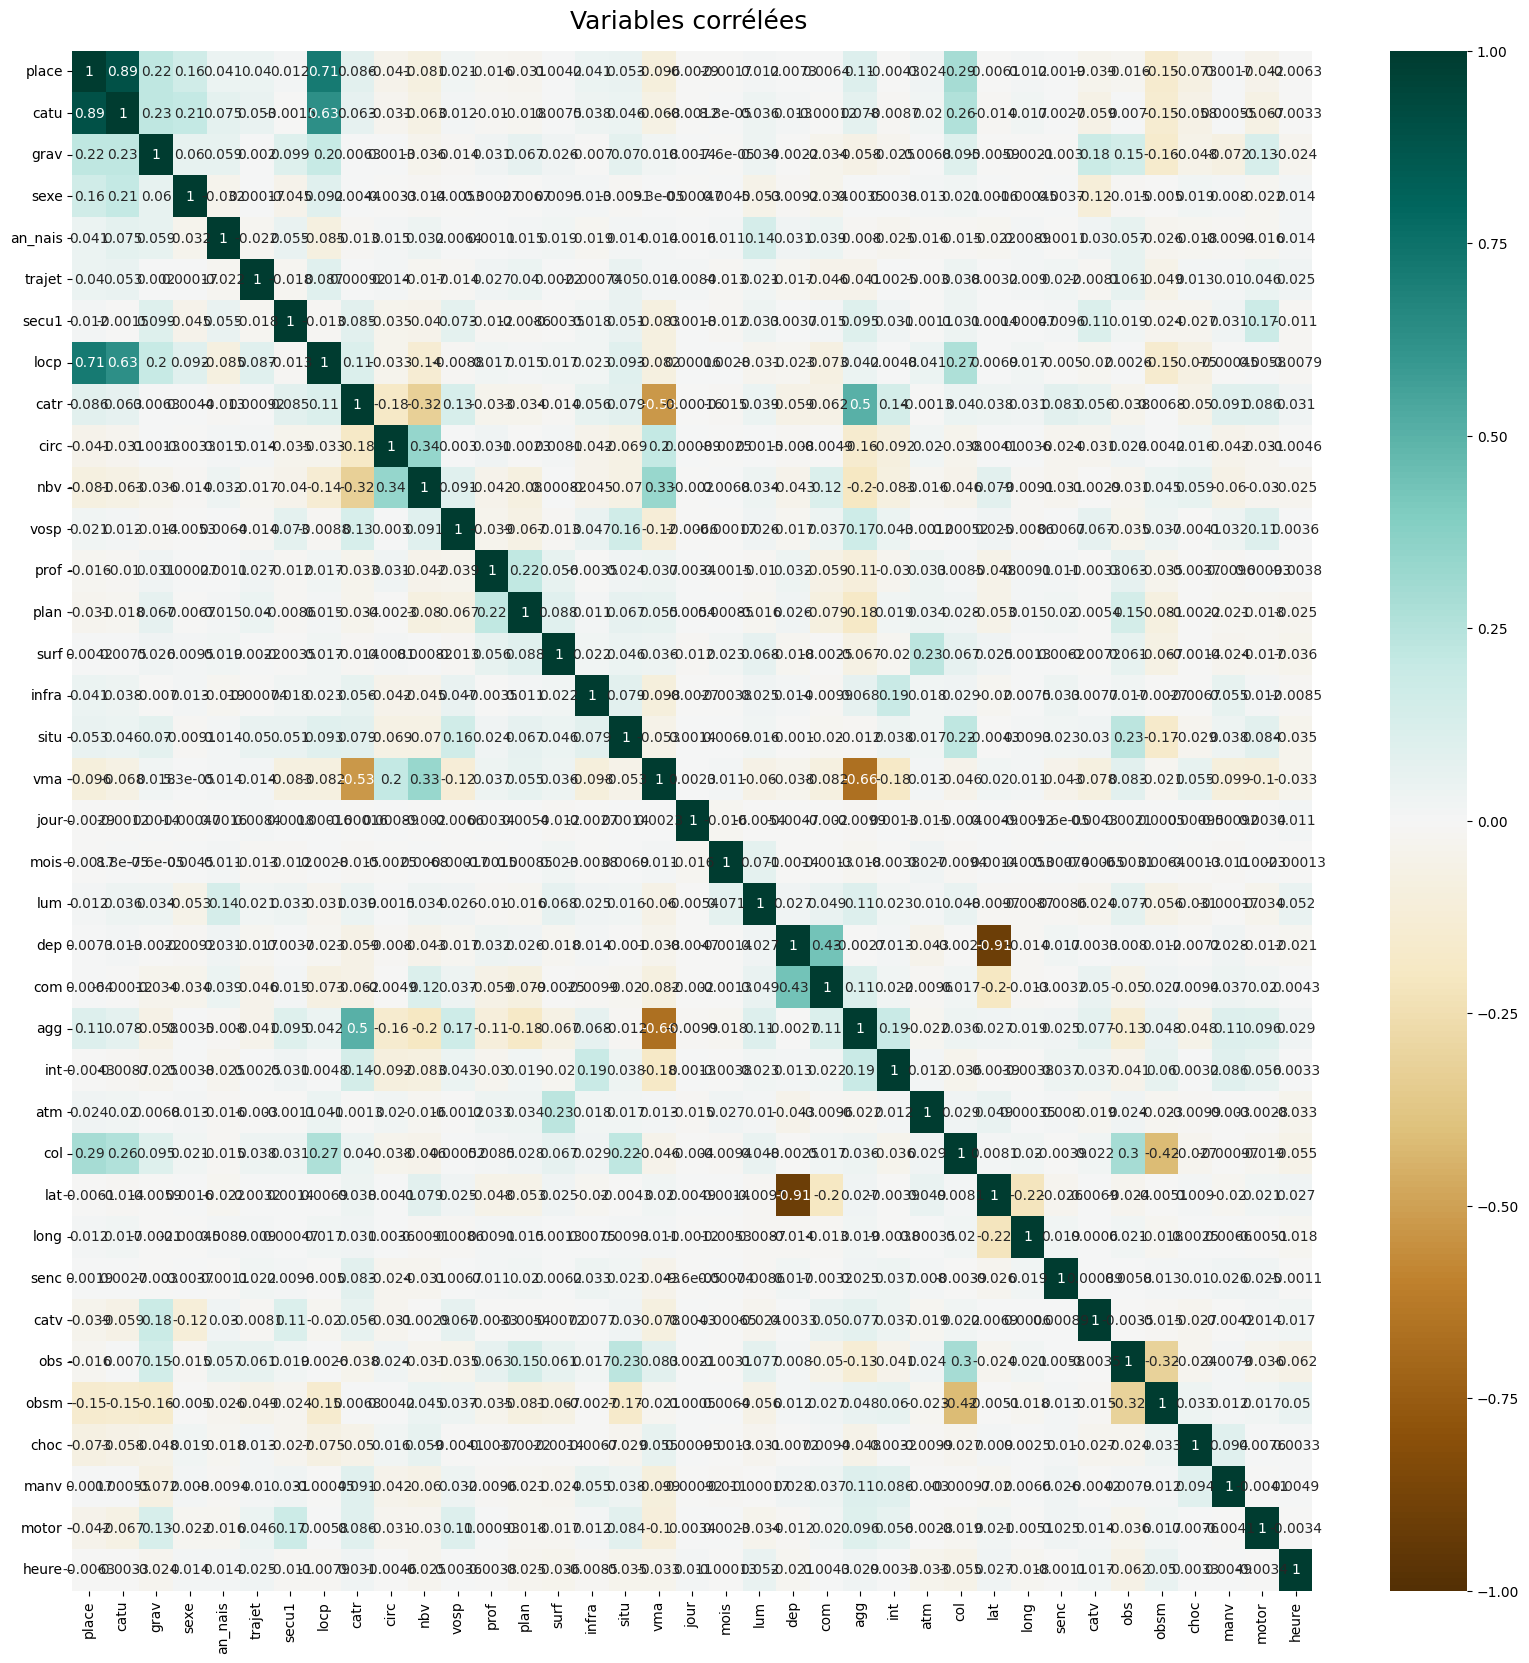

In [ ]:
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Variables corrélées ', fontdict={'fontsize':18}, pad=16)

In [67]:
threshold = 0.5

correlated_pairs = (df.corr().abs() > threshold) & (df.corr().abs() < 1.0)

correlated_variables = correlated_pairs.unstack().reset_index()
correlated_variables = correlated_variables[correlated_variables[0]]


plt.figure(figsize=(8, 6))
sns.heatmap(df.corr().loc[correlated_variables.index, correlated_variables.index],
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Variables Corrélées (Corrélation > 0.5)')
plt.show()

KeyError: "None of [Index([1, 7, 40, 47, 280, 281, 338, 345, 728, 745, 949, 1008, 1018, 1183], dtype='int64')] are in the [index]"

<Figure size 800x600 with 0 Axes>

### Séparation des données

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(["grav"], axis=1), df.grav, test_size=0.3)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Séparation des labels et targets : (319499, 34) (136929, 34) (319499,) (136929,)


In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Choix des modèles

Le choix s'est porté sur les modèles de logistic Regression, AdaBoost et Lgbm, puisqu'ils ne souffrent pas de sur-apprentissage ou de sous-apprentissage tout en offrant de bonnes performances.

### Logistic Regression

#### Choisir la meilleure sélection de variables

In [24]:
# /!\ 

best_accuracy_lr = 0
best_k_lr = 0

for k in range(1, X_train_scaled.shape[1] + 1):
    select_k_best_lr = SelectKBest(score_func=f_classif, k=k)
    
    X_train_k_best_lr = select_k_best_lr.fit_transform(X_train_scaled, y_train)
    X_test_k_best_lr = select_k_best_lr.transform(X_test_scaled)
    
    model_k_lr = OneVsRestClassifier(LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000))
    model_k_lr.fit(X_train_k_best_lr, y_train)
    
    y_pred_k_lr = model_k_lr.predict(X_test_k_best_lr)
    accuracy_k_lr = accuracy_score(y_test, y_pred_k_lr)
    
    if accuracy_k_lr > best_accuracy_lr:
        best_accuracy_lr = accuracy_k_lr
        best_k_lr = k

print("Best number of features:", best_k_lr)
print("Best accuracy:", best_accuracy_lr)

Best number of features: 34
Best accuracy: 0.7425673159082444


#### Application de la meilleure sélection de features

In [25]:
selector = SelectKBest(f_classif, k=best_k_lr)

X_train_kb = selector.fit_transform(X_train_scaled, y_train)
X_test_kb = selector.transform(X_test_scaled)

print(X_train_kb.shape, X_test_kb.shape)

(319499, 34) (136929, 34)


In [26]:
hyper_p_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
#    'penalty': ['l1', 'l2'],              
    'solver': ['liblinear', 'saga']       
}

gs_lr = GridSearchCV(estimator = LogisticRegression(max_iter = 1000),
                           param_grid = hyper_p_lr,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 1,
                           refit=True,
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_lr.fit(X_train_kb, y_train)

best_hp_lr = gs_lr.best_params_
best_score_lr = gs_lr.best_score_

print("Meilleurs paramètres trouvés:", best_hp_lr)
print("Meilleur score de validation croisée:", best_score_lr)

best_model = gs_lr.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Meilleurs paramètres trouvés: {'C': 0.001, 'solver': 'liblinear'}
Meilleur score de validation croisée: 0.7418927617113675


In [27]:
y_pred_lr = best_model.predict(X_test_kb)

report_lr = classification_report(y_test, y_pred_lr)
  
cv_results = gs_lr.cv_results_

print(report_lr)
print(cv_results)

              precision    recall  f1-score   support

           1       0.68      0.71      0.70     57152
           2       0.79      0.76      0.78     79777

    accuracy                           0.74    136929
   macro avg       0.74      0.74      0.74    136929
weighted avg       0.75      0.74      0.74    136929

{'mean_fit_time': array([3.75360551, 4.69459414, 3.80741811, 4.64638233, 3.33439412,
       4.60563045, 3.25846353, 4.42247276, 3.59215531, 4.55861082,
       2.98103204, 3.69884076]), 'std_fit_time': array([0.65299055, 0.23225491, 0.71244761, 0.2803273 , 0.55720316,
       0.27111517, 0.44202073, 0.21368441, 0.73301787, 0.06235549,
       0.21917359, 0.31161315]), 'mean_score_time': array([0.01516333, 0.01593523, 0.01670475, 0.01455073, 0.01304073,
       0.01572857, 0.01326618, 0.01618934, 0.01585975, 0.01629815,
       0.01111517, 0.00603952]), 'std_score_time': array([0.00336877, 0.00295015, 0.00394882, 0.00227332, 0.0025408 ,
       0.00223762, 0.00259549, 0.0

In [36]:
report_lr = classification_report(y_test, y_pred_ada)
  


print(report_lr)

              precision    recall  f1-score   support

           1       0.75      0.77      0.76     57152
           2       0.83      0.81      0.82     79777

    accuracy                           0.80    136929
   macro avg       0.79      0.79      0.79    136929
weighted avg       0.80      0.80      0.80    136929



#### Confusion matrice de logistic regression

Matrice de confusion :
 [[40816 16336]
 [18814 60963]]


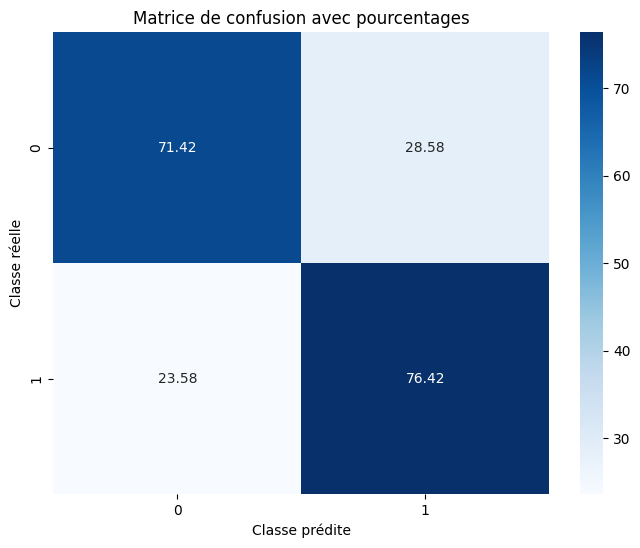

In [28]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Matrice de confusion :\n", cm_lr)

row_sums_lr = cm_lr.sum(axis = 1)
cm_percent_lr = (cm_lr.T / row_sums_lr).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lr, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### Adaboost Classifier

In [29]:
hp_ada = {
    'n_estimators': [200, 250, 300, 350, 400],        # Nombre de classificateurs faibles
    'learning_rate': [0.5, 0.7, 0.8, 0.9, 1],     # Taux d'apprentissage
    'algorithm': ['SAMME', 'SAMME.R']      # Algorithme utilisé; 'SAMME.R' deprecied
}

In [30]:
gs_ada= GridSearchCV(estimator=AdaBoostClassifier(random_state=42),
                           param_grid = hp_ada,
                           cv=5,  # Nombre de folds pour la validation croisée
                           verbose=1,
                           n_jobs=-1)  # Utiliser tous les coeurs du CPU

In [31]:
gs_ada.fit(X_train_kb, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/yu/workspace/acc_route/env_acc_route/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is depr

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.5, 0.7, 0.8, 0.9, 1],
                         'n_estimators': [200, 250, 300, 350, 400]},
             verbose=1)

In [32]:
best_hp_ada = gs_ada.best_params_
best_score_ada = gs_ada.best_score_
best_estimator_ada = gs_ada.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_ada)
print("Meilleur score de validation croisée:", best_score_ada)

Meilleurs paramètres trouvés: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 400}
Meilleur score de validation croisée: 0.7956581955762005


In [33]:
y_pred_ada = best_estimator_ada.predict(X_test_kb)

cv_results_ada = gs_ada.cv_results_

#### Matrice de confusion de Adaboost Classifier

Matrice de confusion :
 [[44251 12901]
 [15133 64644]]


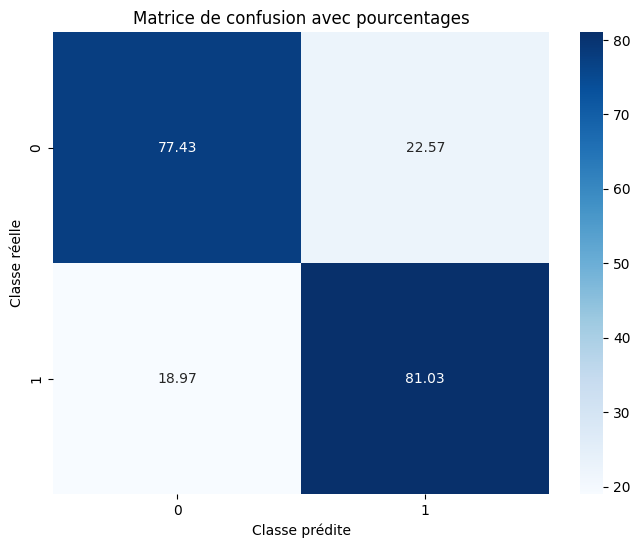

In [34]:
cm_ada = confusion_matrix(y_test, y_pred_ada)
print("Matrice de confusion :\n", cm_ada)

row_sums_ada = cm_ada.sum(axis = 1)
cm_percent_ada = (cm_ada.T / row_sums_ada).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_ada, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### Random forest

In [57]:
hp_rf = {
    'n_estimators': [100, 150, 200, 250],                      # Nombre d'estimateurs
    'criterion' :['gini', 'entropy', 'log_loss'],   # fonction de mesure de la qualité d'une scission
    'max_depth' :[9, 10, 11, 12, 13, 14, 15]                          # profondeur maximale de l'arbre
}

In [58]:
gs_rf = GridSearchCV(estimator=RandomForestClassifier(),
                           param_grid= hp_rf,
                           cv=5,  # Nombre de folds pour la validation croisée
                           verbose=1,
                           refit=True,
                           n_jobs=-1)  # Utiliser tous les coeurs du CPU

In [59]:
gs_rf.fit(X_train_kb, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [9, 10, 11, 12, 13, 14, 15],
                         'n_estimators': [100, 150, 200, 250]},
             verbose=1)

In [60]:
best_hp_rf = gs_rf.best_params_
best_score_rf = gs_rf.best_score_
best_estimator_rf = gs_rf.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_rf)
print("Meilleur score de validation croisée:", best_score_rf)

Meilleurs paramètres trouvés: {'criterion': 'gini', 'max_depth': 15, 'n_estimators': 250}
Meilleur score de validation croisée: 0.8053495432154962


In [61]:
y_pred_rf = best_estimator_rf.predict(X_test_kb)

cv_results_rf = gs_rf.cv_results_

#### Matrice de confusion de Random Forest classifier

Matrice de confusion :
 [[46056 11748]
 [15228 66062]]


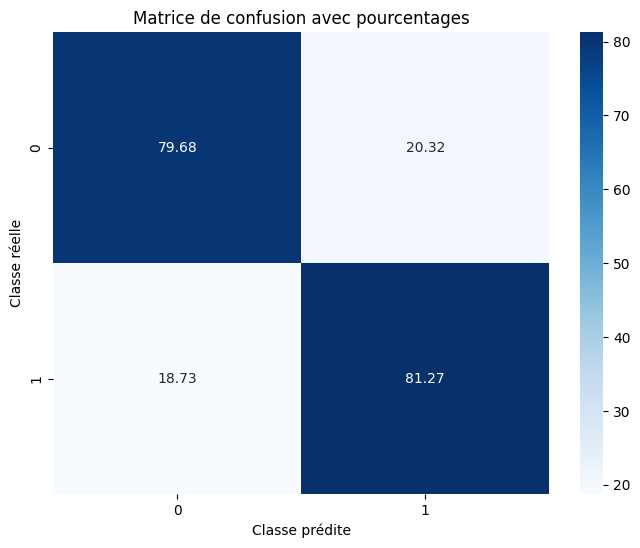

In [62]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Matrice de confusion :\n", cm_rf)

row_sums_rf = cm_rf.sum(axis = 1)
cm_percent_rf = (cm_rf.T / row_sums_rf).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_rf, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### LGBMClassifier

In [86]:
hp_lgbm = {
    'learning_rate': [0.01, 0.1, 1.0],                # Taux d'apprentissage
    'n_estimators': [50, 100],                        # Nombre d'estimateurs
    'num_leaves': [20, 30, 40],                       # Nombre maximum de feuilles par arbre
    'boosting_type': ['gbdt', 'dart', 'goss'],        # Type de boosting
    'subsample': [0.8, 1.0],                          # Sous-échantillonnage des données
    'colsample_bytree': [0.8, 1.0]                   # Fraction de colonnes à utiliser par arbre
}

In [87]:
gs_lgbm = GridSearchCV(estimator=LGBMClassifier(),
                           param_grid= hp_lgbm,
                           cv=5,  # Nombre de folds pour la validation croisée
                           verbose=1,
                           n_jobs=-1)  # Utiliser tous les coeurs du CPU

In [88]:
gs_lgbm.fit(X_train_kb, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Number of positive: 162756, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162757, number of negative: 115429
[LightGBM] [Info] Number of positive: 162756, number of negative: 115430
[LightGBM] [Info] Number of positive: 162757, number of negative: 115430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.011998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

In [1]:
best_hp_lgbm = gs_lgbm.best_params_
best_score_lgbm = gs_lgbm.best_score_
best_estimator_lgbm = gs_lgbm.best_estimator_

print("Meilleurs paramètres trouvés:", best_hp_lgbm)
print("Meilleur score de validation croisée:", best_score_lgbm)

NameError: name 'gs_lgbm' is not defined

In [ ]:
y_pred_lgbm = best_estimator_lgbm.predict(X_test_kb)

cv_results_lgbm = gs_lgbm.cv_results_

#### Matrice de confusion de lgbm classifier

In [ ]:
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Matrice de confusion :\n", cm_lgbm)

row_sums_lgbm = cm_lgbm.sum(axis = 1)
cm_percent_lgbm = (cm_lgbm.T / row_sums_lgbm).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lgbm, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()